In [35]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

In [36]:
# функция для получения пользовательских профилей
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [37]:
# функция для расчёта LTV и ROI
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )
        roi = result.div(cac['cac'], axis=0)
        roi = roi[~roi['cohort_size'].isin([np.inf])]
        roi['cohort_size'] = cohort_sizes
        roi['cac'] = cac['cac']
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]
        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )
    if 'cohort' in dimensions:
        dimensions = []
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    )


In [38]:
visits = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems03_visits.csv')  # журнал сессий
purchases = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_orders.csv')  # покупки
ad_costs = pd.read_csv('C:\\Users\\37544\\Downloads\\ch02_problems02_costs.csv')  # траты на рекламу
events = None  # других событий нет, None — чтобы не «сломать» get_profiles()

In [39]:
# преобразование данных о времени
visits['session_start'] = pd.to_datetime(visits['session_start'])
purchases['event_dt'] = pd.to_datetime(purchases['event_dt'])


In [40]:
# разбиваем траты на рекламу по дням
min_date = datetime(2020, 7, 11)
max_date = datetime(2020, 8, 10)
days_num = (max_date - min_date).days
daily_costs = []
for index, values in ad_costs.iterrows():
    channel_name = values['channel']
    channel_costs = values['costs']
    avg_channel_costs = channel_costs / days_num
    for i in range(days_num):
        current_day = min_date + timedelta(days=i)
        daily_costs += [[current_day, channel_name, avg_channel_costs]]
daily_costs = pd.DataFrame(daily_costs, columns=['dt', 'channel', 'costs'])
daily_costs['dt'] = daily_costs['dt'].dt.date

In [41]:
users = get_profiles(visits, purchases, events, daily_costs)  # профили с CAC

In [42]:
# получите сырые данные, таблицы LTV и ROI, а также таблицы динамики LTV и ROI
ltv_raw, ltv, ltv_history, roi, roi_history = get_ltv(
   users, purchases, datetime(2020, 8, 10).date(), 7, dimensions=['channel']
)

In [76]:
# исключите размеры когорт и CAC из таблицы ROI
report = roi.drop(columns=['cohort_size', 'cac'])
#report = roi.drop(columns=['cac'])

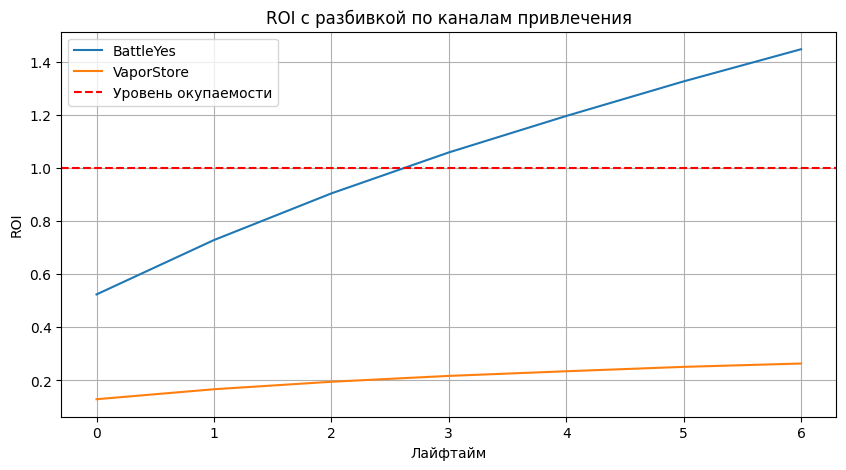

In [79]:
# строим кривые ROI
report.T.plot(grid=True, figsize=(10, 5), xticks=list(report.columns.values))
plt.title('ROI с разбивкой по каналам привлечения')
plt.ylabel('ROI')
plt.xlabel('Лайфтайм')
plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
plt.legend()
plt.show()